In [2]:
import sys
import os

# Add the parent directory of 'src' to sys.path
sys.path.append(os.path.abspath('../src'))

# Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from neural_network.utils import one_hot_encode, normalize_data, plot_confusion_matrix, plot_loss_and_accuracy_curve
from neural_network.losses import CategoricalCrossEntropyLoss
from neural_network.layers.dense_layer import DenseLayer
from neural_network.layers.dense_l2_layer import L2DenseLayer
from neural_network.layers.dropout_layer import DropoutLayer
from neural_network.optimizer import GradientDescent

In [3]:
# Carregar o arquivo CSV
data = pd.read_csv('../data/multiclass/online_gaming_behavior.csv')

# Exibir primeiras linhas do dataset
data.head()

,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,9000,43,Male,Other,Strategy,16.271119,0,Medium,6,108,79,25,Medium
1,9001,29,Female,USA,Strategy,5.525961,0,Medium,5,144,11,10,Medium
2,9002,22,Female,USA,Sports,8.223755,0,Easy,16,142,35,41,High
3,9003,35,Male,USA,Action,5.265351,1,Easy,9,85,57,47,Medium
4,9004,33,Male,Europe,Action,15.531945,0,Medium,2,131,95,37,Medium


In [4]:
# Selecionar colunas categóricas
categorical_columns = ['Gender', 'Location', 'GameGenre', 'GameDifficulty', 'EngagementLevel']

# Mapear cada categoria para um número
for column in categorical_columns:
    data[column] = data[column].astype('category').cat.codes

# Obter o número de classes para cada coluna categórica
num_classes = {column: data[column].nunique() for column in categorical_columns}

# Aplicar One-Hot Encoding
for column in categorical_columns:
    one_hot_encoded = one_hot_encode(data[column].values, num_classes[column])

    # Adicionar as colunas one-hot ao dataframe
    for i in range(num_classes[column]):
        data[f"{column}_{i}"] = one_hot_encoded[:, i]

    # Remover a coluna categórica original
    data = data.drop(column, axis=1)

# Exibir o dataset transformado
data.head()

,PlayerID,Age,PlayTimeHours,InGamePurchases,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,Gender_0,Gender_1,...,GameGenre_1,GameGenre_2,GameGenre_3,GameGenre_4,GameDifficulty_0,GameDifficulty_1,GameDifficulty_2,EngagementLevel_0,EngagementLevel_1,EngagementLevel_2
0,9000,43,16.271119,0,6,108,79,25,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,9001,29,5.525961,0,5,144,11,10,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,9002,22,8.223755,0,16,142,35,41,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,9003,35,5.265351,1,9,85,57,47,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,9004,33,15.531945,0,2,131,95,37,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [5]:
# Definir X (entrada) e y (saída)
cleared_data = data.drop(['PlayerID', 'EngagementLevel_0', 'EngagementLevel_1', 'EngagementLevel_2'], axis=1)
print(cleared_data.columns)

X = cleared_data.values
y = one_hot_encode(data[['EngagementLevel_0', 'EngagementLevel_1', 'EngagementLevel_2']].values.argmax(axis=1), 3)

# Normalizar os dados de entrada
X = normalize_data(X)

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dividir os dados de treino em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

Index(['Age', 'PlayTimeHours', 'InGamePurchases', 'SessionsPerWeek',
       'AvgSessionDurationMinutes', 'PlayerLevel', 'AchievementsUnlocked',
       'Gender_0', 'Gender_1', 'Location_0', 'Location_1', 'Location_2',
       'Location_3', 'GameGenre_0', 'GameGenre_1', 'GameGenre_2',
       'GameGenre_3', 'GameGenre_4', 'GameDifficulty_0', 'GameDifficulty_1',
       'GameDifficulty_2'],
      dtype='object')


In [6]:
class NeuralNetwork:
    def __init__(self, layers, loss, optimizer):
        self.layers = layers
        self.loss = loss
        self.optimizer = optimizer
        
    def forward(self, X):
        output = X
        for layer in self.layers:
            output = layer.forward(output)
        return output
    
    def backward(self, y_true, y_pred):
        grad = self.loss.backward(y_true, y_pred)
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
    
    def update(self):
        for layer in self.layers:
            params = layer.get_parameters()
            if params:
                grads = layer.get_gradients()
                weights_updated, biases_updated = self.optimizer.update(
                    params['weights'], params['biases'],
                    grads['weights'], grads['biases']
                )
                layer.set_parameters({'weights': weights_updated, 'biases': biases_updated})

In [7]:
# Definir a arquitetura da rede neural
input_size = X_train.shape[1]
output_size = y_train.shape[1]

layers = [
    DenseLayer(input_size=input_size, output_size=256, activation='relu'),
    DropoutLayer(rate=0.05),
    DenseLayer(input_size=256, output_size=128, activation='relu'),
    DropoutLayer(rate=0.1),
    DenseLayer(input_size=128, output_size=128, activation='relu'),
    DropoutLayer(rate=0.2),
    DenseLayer(input_size=128, output_size=64, activation='relu'),
    DenseLayer(input_size=64, output_size=32, activation='relu'),
    DenseLayer(input_size=32, output_size=output_size, activation='softmax'),
]

loss = CategoricalCrossEntropyLoss()
optimizer = GradientDescent(learning_rate=0.015)

# Criar o modelo
model = NeuralNetwork(layers=layers, loss=loss, optimizer=optimizer)

In [8]:
import time
import numpy as np

# Configurações do tamanho do batch dinâmico

# O batch size é o número total de amostras
#batch_size = X_train.shape[0]
initial_batch_size = 256
final_batch_size = 8192
batch_growth_rate = 32  # Taxa de aumento por época

epochs = 400
best_val_loss = float('inf')
early_stop_threshold = 5
#0-5x actual val não foi melhor que best
no_improvement = 0

initial_learning_rate = optimizer.learning_rate
decay_rate = 0.001
decay_step = 10

loss_history = []
reg_loss_history = []
total_loss_history = []
accuracy_history = []


#Timer
start_time = time.time()

# Treinar a rede neural
for epoch in range(epochs):
    # Ajustar Learning Rate
    if epoch % decay_step == 0 and epoch > 0:
        optimizer.learning_rate *= (1 - decay_rate)
        print(f"\nAdjusted Learning Rate: {optimizer.learning_rate:.6f}\n")
    
    # Atualizar o tamanho do batch
    batch_size = min(initial_batch_size + epoch * batch_growth_rate, final_batch_size)
    #batch_size = initial_batch_size

    # Dividir os dados em batches
    num_batches = int(np.ceil(X_train.shape[0] / batch_size))
    epoch_loss = 0
    epoch_accuracy = 0

    for batch in range(num_batches):
        # Criar batches
        start = batch * batch_size
        end = min((batch + 1) * batch_size, X_train.shape[0])
        X_batch = X_train[start:end]
        y_batch = y_train[start:end]

        # Forward pass
        y_pred = model.forward(X_batch)

        # Calcular losses
        main_loss = loss.calculate(y_batch, y_pred)
        reg_loss = sum(
            layer.compute_regularization_loss() 
            for layer in model.layers 
            if isinstance(layer, L2DenseLayer)
        )
        total_loss = main_loss + reg_loss
        epoch_loss += total_loss

        # Backward e update
        model.backward(y_batch, y_pred)
        model.update()

        # Calcular acurácia do batch
        predictions = y_pred.argmax(axis=1)
        y_true = y_batch.argmax(axis=1)
        epoch_accuracy += accuracy_score(y_true, predictions)

    # Média das métricas por época
    epoch_loss /= num_batches
    epoch_accuracy /= num_batches

    # Validação
    y_val_pred = model.forward(X_val)
    val_loss = loss.calculate(y_val, y_val_pred)
    val_accuracy = accuracy_score(y_val.argmax(axis=1), y_val_pred.argmax(axis=1))

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement = 0
    else:
        no_improvement += 1
        if no_improvement >= early_stop_threshold:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    # Relatório a cada 10 épocas
    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch {epoch + 1} - Batch Size: {batch_size}\n"
            f" Train -> Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}\n"
            f" Validation -> Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}"
        )

    # Guardar histórico
    loss_history.append(epoch_loss)
    reg_loss_history.append(reg_loss)
    total_loss_history.append(epoch_loss)
    accuracy_history.append(epoch_accuracy)

elapsed_time = time.time() - start_time


Epoch 10 - Batch Size: 544
 Train -> Loss: 0.9290, Accuracy: 0.5423
 Validation -> Loss: 0.9131, Accuracy: 0.5556

Adjusted Learning Rate: 0.014985

Epoch 20 - Batch Size: 864
 Train -> Loss: 0.8051, Accuracy: 0.6338
 Validation -> Loss: 0.7927, Accuracy: 0.6420

Adjusted Learning Rate: 0.014970

Epoch 30 - Batch Size: 1184
 Train -> Loss: 0.7470, Accuracy: 0.6777
 Validation -> Loss: 0.7384, Accuracy: 0.6795

Adjusted Learning Rate: 0.014955

Epoch 40 - Batch Size: 1504
 Train -> Loss: 0.7172, Accuracy: 0.7016
 Validation -> Loss: 0.7116, Accuracy: 0.6980

Adjusted Learning Rate: 0.014940

Epoch 50 - Batch Size: 1824
 Train -> Loss: 0.7022, Accuracy: 0.7091
 Validation -> Loss: 0.6959, Accuracy: 0.7110

Adjusted Learning Rate: 0.014925

Epoch 60 - Batch Size: 2144
 Train -> Loss: 0.6931, Accuracy: 0.7182
 Validation -> Loss: 0.6856, Accuracy: 0.7202

Adjusted Learning Rate: 0.014910

Epoch 70 - Batch Size: 2464
 Train -> Loss: 0.6882, Accuracy: 0.7227
 Validation -> Loss: 0.6781, Accu


Métricas Finais:
Train Accuracy: 0.7681
Validation Accuracy: 0.7655
Train Loss: 0.6205
Validation Loss: 0.6251
Learning Rate: 0.01442597914017735
Camadas: 9
Tempo de Treino: 229.48s
Batch Size Final: 8192


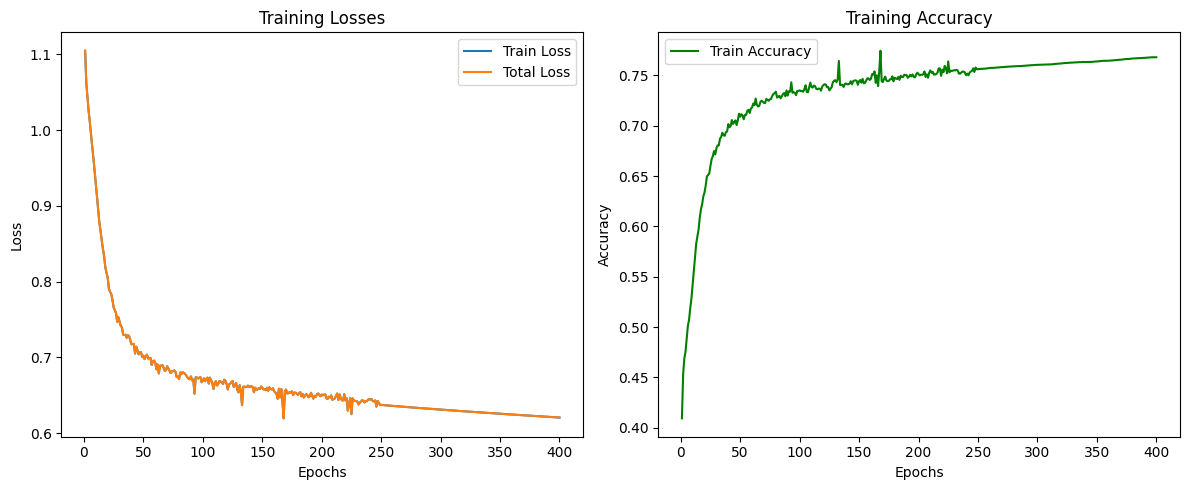

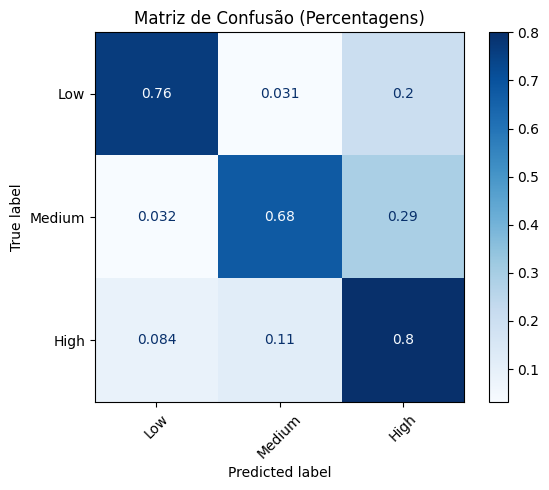

In [9]:
# Relatórios finais
print(f"\nMétricas Finais:")
print(f"Train Accuracy: {epoch_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Train Loss: {epoch_loss:.4f}")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Learning Rate: {optimizer.learning_rate}")
print(f"Camadas: {len(model.layers)}")
print(f"Tempo de Treino: {elapsed_time:.2f}s")
print(f"Batch Size Final: {batch_size}")

# Plot loss and accuracy graph
plot_loss_and_accuracy_curve(loss_history, total_loss_history, accuracy_history)

# Calcular as previsões no conjunto de teste
y_test_pred = model.forward(X_test).argmax(axis=1)  # Previsões do modelo
y_test_true = y_test.argmax(axis=1)                # Classes verdadeiras

# Exibir a matriz de confusão
labels = ["Low", "Medium", "High"]  # Ajustar conforme suas classes
plot_confusion_matrix(y_test_true, y_test_pred, labels=labels)

In [ ]:
# Fazer previsões no conjunto de teste
y_pred_test = model.forward(X_test)
predictions_test = y_pred_test.argmax(axis=1)
y_true_test = y_test.argmax(axis=1)

# Calcular métricas de desempenho
print("\nClassification Report:")
print(classification_report(y_true_test, predictions_test))

# Acurácia
accuracy = accuracy_score(y_true_test, predictions_test)
print(f"Test Accuracy: {accuracy:.4f}")